
### 코드 설명

1. **CIFAR-100 사전학습:**  
   CIFAR-100 데이터셋을 사용해 `SimpleCNN` 모델을 5 에폭 동안 학습한 후, 가중치를 저장합니다.

2. **MNIST 데이터 전처리:**  
   MNIST 이미지를 32×32, 3채널로 변환하여 CIFAR-100 모델에 맞게 전처리합니다.

3. **MNIST Full Fine-tuning:**  
   - CIFAR-100 사전학습된 feature extractor를 불러온 후, classifier의 마지막 레이어를 `Linear(256, 10)`으로 교체합니다.  
   - 전체 네트워크를 업데이트하며 (전체 파라미터 학습), 작은 학습률(1e-4)을 사용합니다.  
   - 에폭별 train/validation loss와 accuracy를 각각 `ft_train_losses`, `ft_train_accs`, `ft_val_losses`, `ft_val_accs`에 저장합니다.

4. **MNIST Feature Extraction:**  
   - 동일하게 사전학습된 feature extractor를 로드한 후, feature extractor는 고정시키고 classifier만 재정의하여 업데이트합니다.  
   - classifier만 업데이트합니다. 학습률은 1e-3을 사용합니다.  
   - 에폭별 metric은 `fe_train_losses`, `fe_train_accs`, `fe_val_losses`, `fe_val_accs`에 저장합니다.

5. **성능 비교 Plot:**  
   - 두 실험의 Accuracy와 Loss를 각각 plot하여 비교합니다.

이 코드를 실행하면 두 접근법의 에폭별 성능 변화를 비교할 수 있는 plot이 생성됩니다.

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import math

# 이미지를 시각화하는 함수



In [2]:
# 이미지 시각화를 위한 함수 (단일 이미지 표시용)
def imshow(img, title=None, cmap=None):
    npimg = img.numpy()
    if npimg.shape[0] == 1:  # 흑백 이미지의 경우
        npimg = npimg[0]
    else:
        npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

def print_dataset_info(name, train_set, test_set):
    sample_img, sample_label = train_set[0]
    print(f"========== {name} ==========")
    print("Train 샘플 개수:", len(train_set))
    print("Test 샘플 개수:", len(test_set))
    print("샘플 이미지 텐서 shape:", sample_img.shape)  # (채널, 높이, 너비)
    if hasattr(train_set, 'classes'):
        print("클래스 (카테고리) 개수:", len(train_set.classes))
        print("클래스 이름:", train_set.classes)
    print()

def visualize_one_per_category(dataset, dataset_name="Dataset", cmap=None):
    """
    각 카테고리에서 1개의 샘플 이미지를 수집하여 한 화면에 grid로 시각화합니다.
    - dataset: torchvision 데이터셋 (transform이 적용된 상태)
    - dataset_name: 데이터셋 이름 (출력 제목에 사용)
    - cmap: 흑백일 경우 'gray' 지정
    """
    samples = {}  # key: label, value: 이미지 텐서

    # dataset.targets (또는 train_labels)를 통해 클래스 정보를 확인
    targets = dataset.targets if hasattr(dataset, 'targets') else dataset.train_labels

    # sample에 이미지 추가
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        # label이 tensor인 경우 정수형으로 변환
        if torch.is_tensor(label):
            label = label.item()
        if label not in samples:
            samples[label] = img
        if len(samples) >= len(dataset.classes):
            break

    n_categories = len(dataset.classes)
    print(f"{dataset_name} 카테고리 개수: {n_categories}")

    # Grid 배치를 위해 (예: 10열로 배치)
    cols = 10 if n_categories >= 10 else n_categories
    rows = math.ceil(n_categories / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    # axes가 2차원 배열인 경우 flatten하여 사용
    if rows * cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # 클래스 id 오름차순으로 정렬하여 시각화
    for i, label in enumerate(sorted(samples.keys())):
        ax = axes[i]
        img = samples[label]
        npimg = img.numpy()
        if npimg.shape[0] == 1:  # 흑백 이미지
            npimg = npimg[0]
            ax.imshow(npimg, cmap=cmap)
        else:
            npimg = np.transpose(npimg, (1, 2, 0))
            ax.imshow(npimg)
        class_name = dataset.classes[label] if hasattr(dataset, 'classes') else str(label)
        ax.set_title(class_name, fontsize=8)
        ax.axis('off')

    # 남은 subplot 축 숨기기 (있을 경우)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"{dataset_name} - 1 sample per category", fontsize=14)
    plt.tight_layout()
    plt.show()

# CIFAR-100 데이터셋 (3채널 컬러 이미지, 32x32)

In [30]:
# Jupyter에서는 현재 작업 디렉토리를 기준으로
# data_root = Path.cwd() / 'common' / 'data'

# 루트 디렉토리를 기준으로 data 디렉토리 경로 설정
from pathlib import Path

def find_project_root(folder_name='codeit') -> Path:
    p = Path.cwd()
    while p.name != folder_name:
        if p.parent == p:
            raise RuntimeError(f"'{folder_name}' 폴더를 찾을 수 없습니다.")
        p = p.parent
    return p

project_root = find_project_root()  # 현재 위치에서 codeit 폴더까지 위로 올라감
print(f'as: ', project_root)
data_root = project_root / 'common' / 'data'

print("MNIST 데이터 저장 위치:", data_root)


as:  /Users/carki/Desktop/Dev/codeit
MNIST 데이터 저장 위치: /Users/carki/Desktop/Dev/codeit/common/data


In [15]:
# --------------------------------------------------
# 데이터셋 준비
# --------------------------------------------------
# CIFAR-100 데이터셋 (3채널 컬러 이미지, 32x32)
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # 옵션: 정규화
])

cifar_train = torchvision.datasets.CIFAR100(
    root=str(data_root),
    train=True,
    download=True,
    transform=transform_cifar
)

cifar_test = torchvision.datasets.CIFAR100(
    root=str(data_root),
    train=False,
    download=True,
    transform=transform_cifar
)

100%|██████████| 169M/169M [00:27<00:00, 6.10MB/s] 


# MNIST 데이터셋 (1채널 흑백 이미지, 28x28)

In [16]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))  # 옵션: 정규화
])

mnist_train = datasets.MNIST(
    root=str(data_root),
    train=True,
    download=True,
    transform=transform_mnist
)

mnist_test = datasets.MNIST(
    root=str(data_root),
    train=False,
    download=True,
    transform=transform_mnist
)





100%|██████████| 9.91M/9.91M [00:02<00:00, 3.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.36MB/s]


========== CIFAR100 ==========
Train 샘플 개수: 50000
Test 샘플 개수: 10000
샘플 이미지 텐서 shape: torch.Size([3, 32, 32])
클래스 (카테고리) 개수: 100
클래스 이름: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 

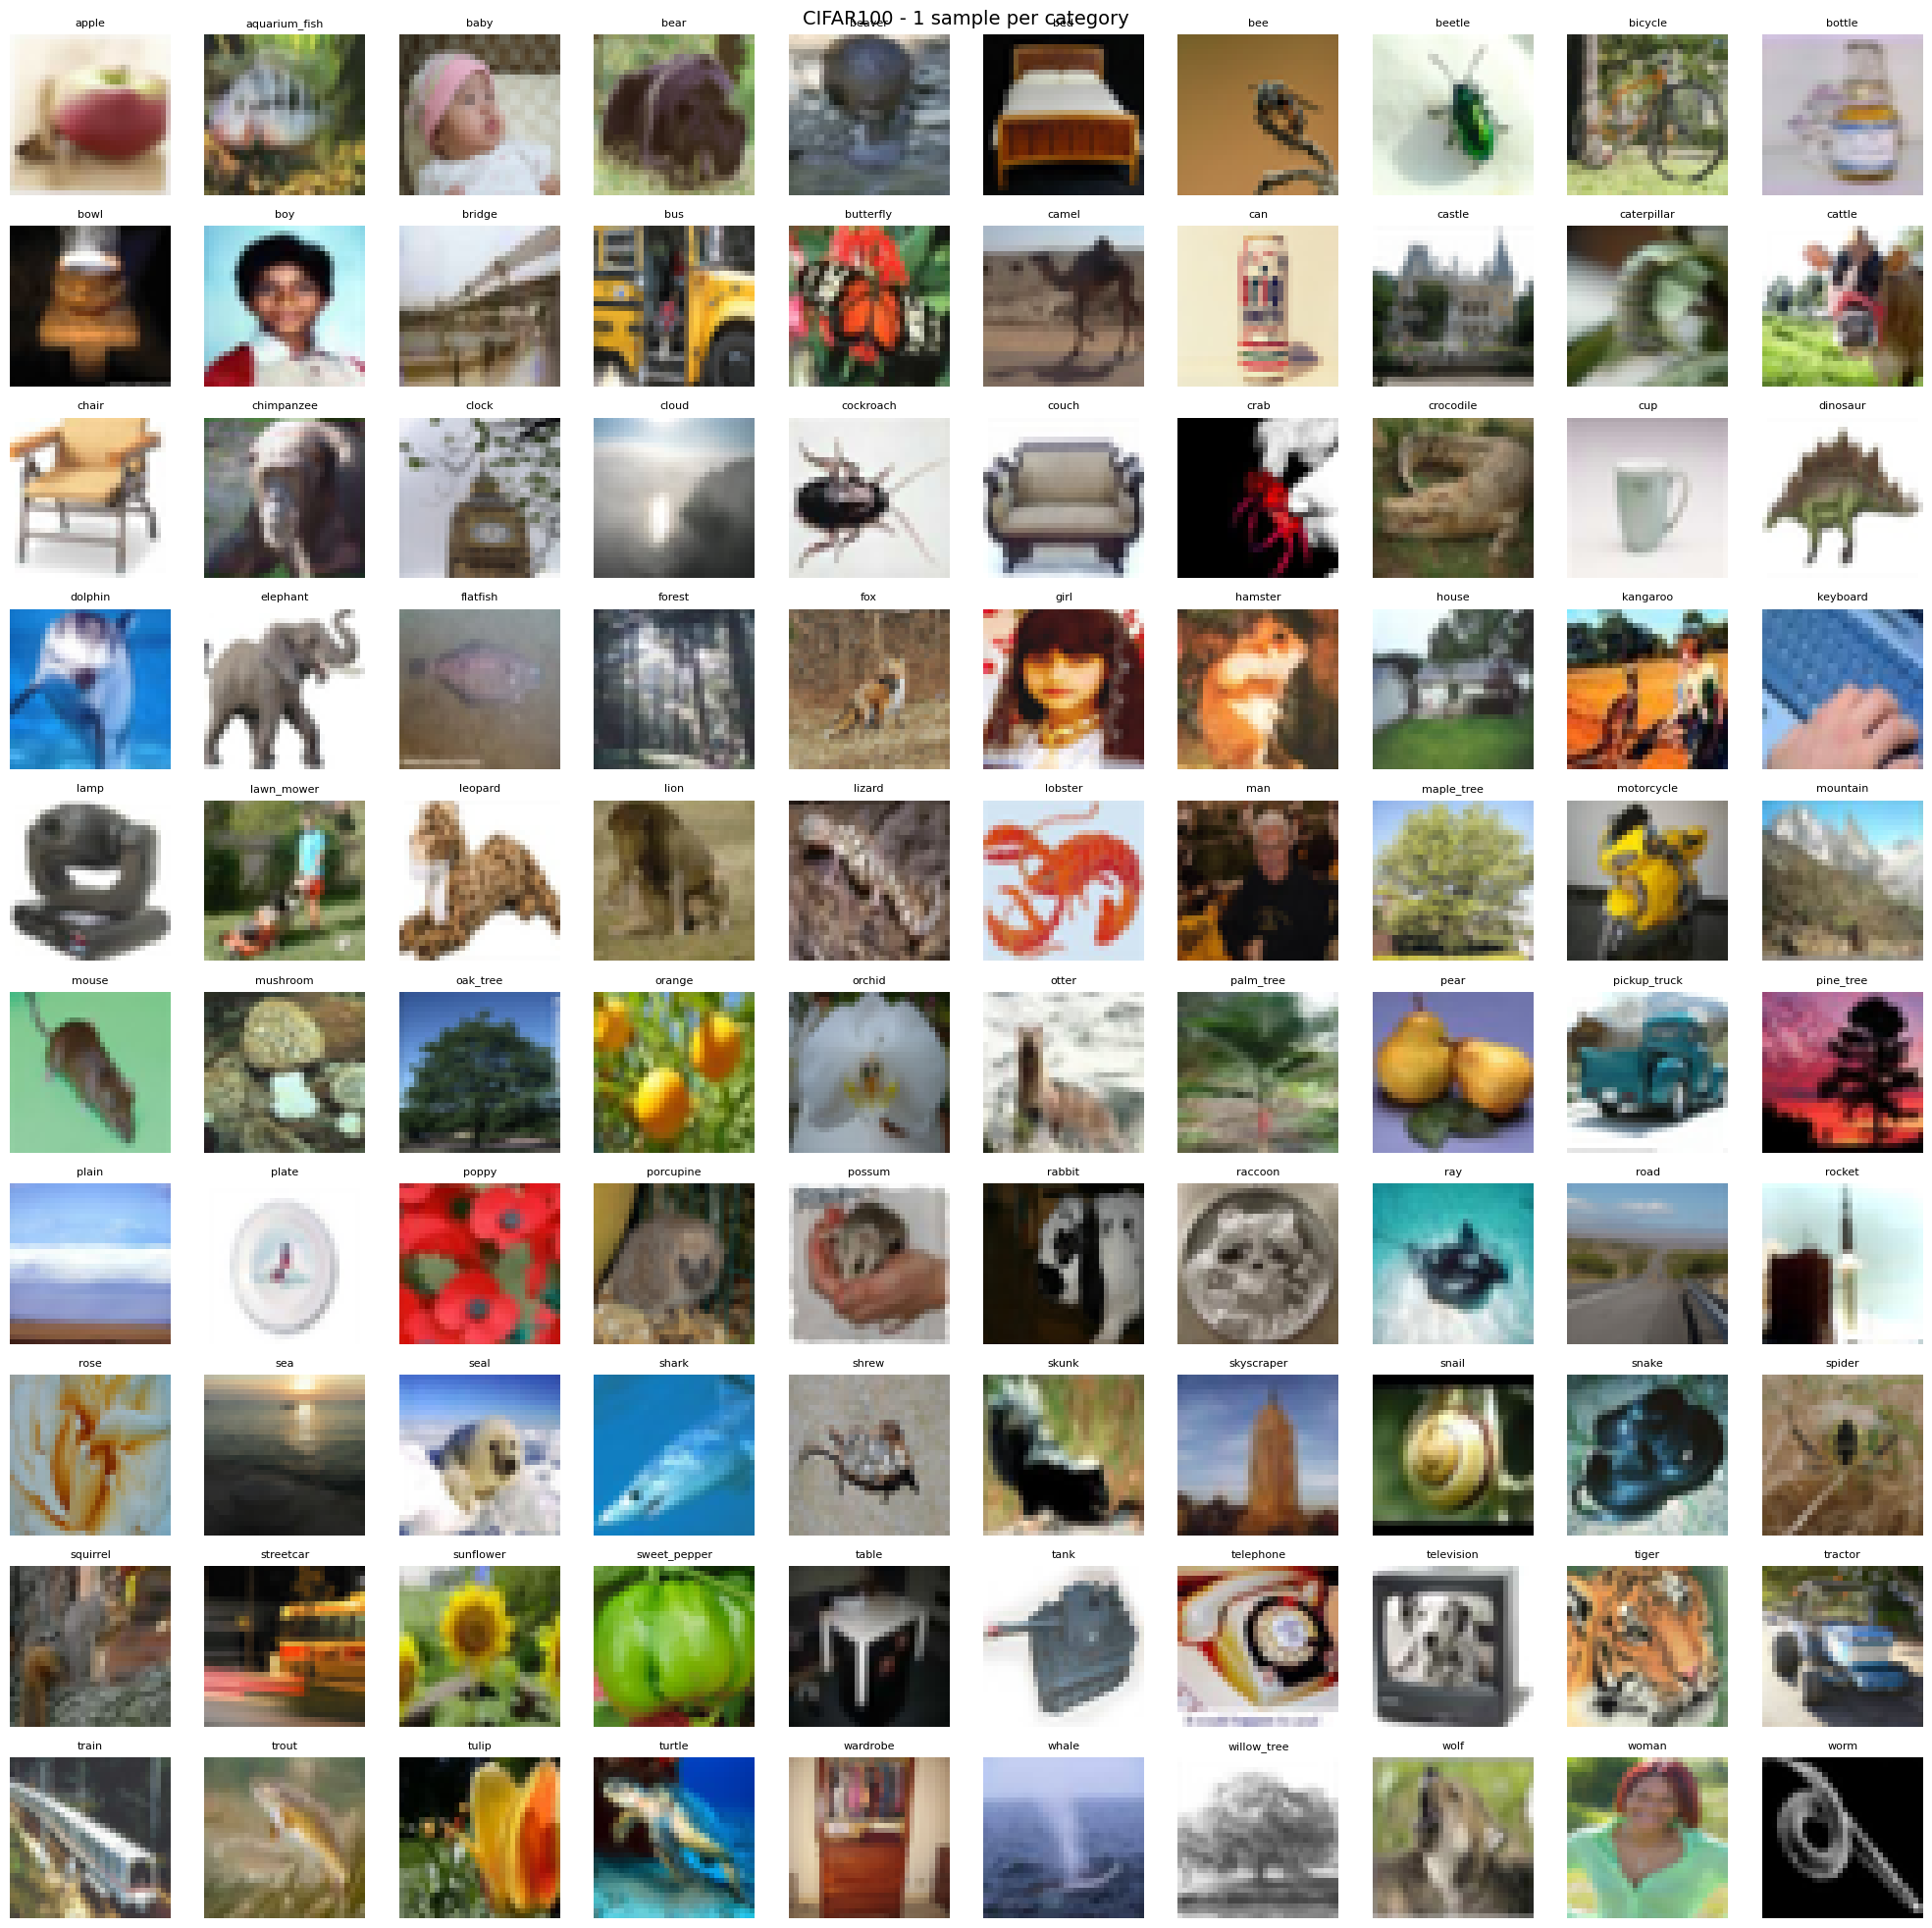

MNIST 카테고리 개수: 10


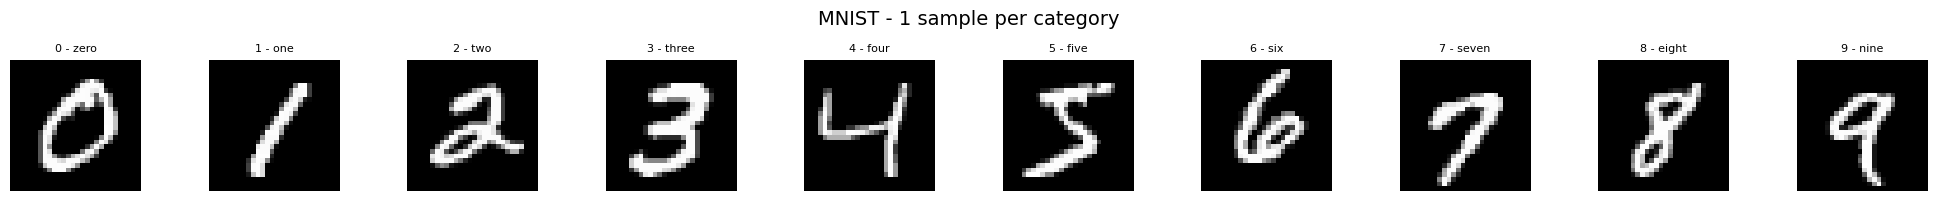

In [5]:
# --------------------------------------------------
# 데이터셋 정보 출력
# --------------------------------------------------
print_dataset_info("CIFAR100", cifar_train, cifar_test)
print_dataset_info("MNIST", mnist_train, mnist_test)

# --------------------------------------------------
# 각 카테고리별로 1개의 샘플 이미지를 시각화
# --------------------------------------------------
visualize_one_per_category(cifar_train, dataset_name="CIFAR100", cmap=None)
visualize_one_per_category(mnist_train, dataset_name="MNIST", cmap='gray')


In [7]:
from PIL import Image

# MNIST 데이터셋에서 첫 번째 이미지 로드 (그레이스케일)
mnist = datasets.MNIST(root='./data', train=True, download=True)
gray_img_array = mnist.data[0].numpy()  # shape: [28, 28]
gray_img_pil = Image.fromarray(gray_img_array, mode='L')  # PIL 이미지, 모드 'L' (그레이스케일)

# 1채널 -> 3채널 데이터로 변환
# 방법 1: transforms.Grayscale(num_output_channels=3) 사용
transform_to3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
img_method1 = transform_to3(gray_img_pil)  # 텐서 shape: [3, 28, 28]
print(img_method1.shape)

# 방법 2: PIL의 convert("RGB") 사용 후 ToTensor()
# transforms v2를 사용할 경우
# toimg = transforms.v2.ToImage()
# toimage(gray_img_pil)
img_method2 = transforms.ToTensor()(gray_img_pil.convert("RGB"))  # 텐서 shape: [3, 28, 28]
print(img_method2)

# 두 결과의 차이 계산
diff = torch.abs(img_method1 - img_method2)
max_diff = diff.max().item()
mean_diff = diff.mean().item()

print("두 방법의 최대 차이 (Max Difference):", max_diff)
print("두 방법의 평균 차이 (Mean Difference):", mean_diff)

torch.Size([3, 28, 28])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
두 방법의 최대 차이 (Max Difference): 0.0
두 방법의 평균 차이 (Mean Difference): 0.0


# 시각화 (세 이미지: 원본, 방법1, 방법2)

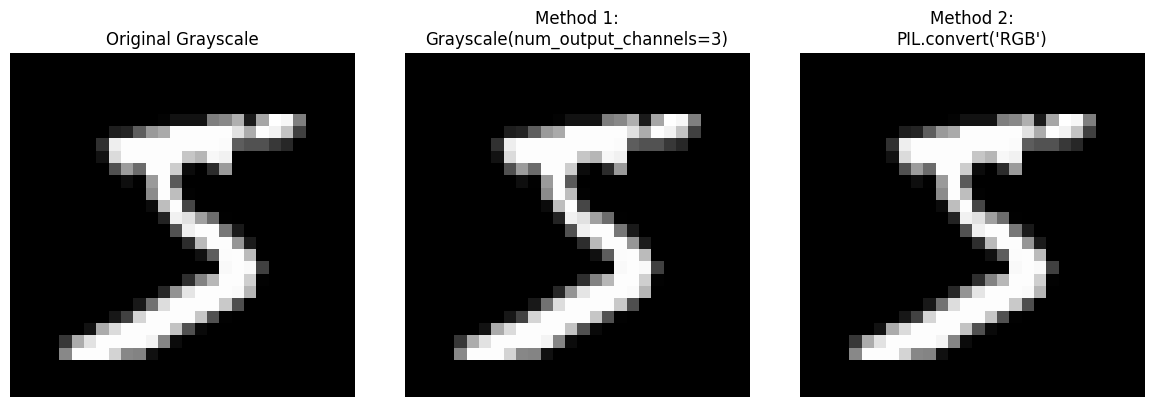

In [8]:
def imshow_tensor(img_tensor, title=None):
    np_img = img_tensor.numpy().transpose(1, 2, 0)
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gray_img_pil, cmap='gray')
plt.title("Original Grayscale")
plt.axis('off')

plt.subplot(1, 3, 2)
imshow_tensor(img_method1, title="Method 1:\nGrayscale(num_output_channels=3)")

plt.subplot(1, 3, 3)
imshow_tensor(img_method2, title="Method 2:\nPIL.convert('RGB')")

plt.tight_layout()
plt.show()
